In [1]:
import astropy.units as u
from astropy.coordinates.sky_coordinate import SkyCoord
from astropy.units import Quantity
from astroquery.gaia import Gaia
import matplotlib.pyplot as plt
import numpy as np
import time
from astroquery.simbad import Simbad
import astropy 
from astropy.table import Table
%matplotlib inline

Created TAP+ (v1.2.1) - Connection:
	Host: gea.esac.esa.int
	Use HTTPS: True
	Port: 443
	SSL Port: 443
Created TAP+ (v1.2.1) - Connection:
	Host: geadata.esac.esa.int
	Use HTTPS: True
	Port: 443
	SSL Port: 443


In [2]:
from joblib import Memory
cachedir = "./joblib_cache"
memory = Memory(cachedir, verbose=0, bytes_limit=1e7)

In [3]:
@memory.cache
def get_gaia_query(q):
    """checks request against previous querys and returns a table containing the results of the query
    
    returns: astropy table"""
    start = time.time()
    job = Gaia.launch_job_async(q)
    print(f"Total time: {time.time() - start:0.2f} sec")
    return job.get_results()

In [4]:
def get_RA(simbad_tbl):
    """returns the values of the right ascension in hour minute second units"""
    angle = simbad_tbl["RA"][0].replace(" ", ":")
    return HMS_to_degrees(angle)

def get_DEC(simbad_tbl):
    """returns the values of the declination in degree arcmin arcsec units"""
    angle = simbad_tbl["DEC"][0].replace(" ", ":")
    return DMS_to_degrees(angle)

def get_PMRA(simbad_tbl):
    """returns the value of the right ascension of the proper motion"""
    return float(simbad_tbl["PMRA"][0])

def get_PMDEC(simbad_tbl):
    """returns the value of the right ascension of the proper motion"""
    return float(simbad_tbl["PMDEC"][0])

def get_PARALLAX(simbad_tbl):
    """returns the value of the parallax of the object"""
    return float(simbad_tbl["PLX_VALUE"][0])

def HMS_to_degrees(angle):
    from astropy.coordinates import Angle
    ac = Angle(angle, unit='hour')
    deg = float(ac.to_string(unit='degree', decimal=True))
    return deg

def DMS_to_degrees(angle):
    from astropy.coordinates import Angle
    ac = Angle(angle, unit='degree')
    deg = float(ac.to_string(unit='degree', decimal=True))
    return deg

def get_parameters(cluster_name):
    """returns the RA, DEC, PMRA, PMDEC, and parallax of a given cluster
    RA in units of degrees
    DEC in units of degrees
    PMRA in units of mas/yr
    PMDEC in units of mas/yr
    parallax in mas, if given, otherwise given as 'nan' """
    customSimbad = Simbad()
    customSimbad.add_votable_fields('parallax', 'plx')
    customSimbad.add_votable_fields('pmra', 'pmra')
    customSimbad.add_votable_fields('pmdec', 'pmdec')
    
    cluster = customSimbad.query_object(cluster_name)
    
    ra = get_RA(cluster)
    dec= get_DEC(cluster)
    pmra = get_PMRA(cluster)
    pmdec = get_PMDEC(cluster)
    parallax = get_PARALLAX(cluster)
    
    return np.asarray([ra, dec, pmra, pmdec, parallax])

In [5]:
hyades_parameters = get_parameters("Hyades")
M67_parameters = get_parameters("M67")
NGC6397_parameters = get_parameters("NGC 6397")
NGC6397_parameters[4] = 0.418

/Users/DanielBautista/opt/miniconda3/envs/astroconda/lib/python3.6/site-packages/ipykernel_launcher.py:21: UserWarning: Warning: converting a masked element to nan.


In order to be able to use Gaia data to identify members of star clusters, I first need to explore the data to see how it appears under different cuts in the parameters. To start the investigation of the Gaia data, I will start by only making cuts in the position in the sky and the parallax, and plot the proper motion in right ascension against the proper motion in declination and see if there is any grouping of the stars. 

In [6]:
hyades_exploratory_window = (hyades_parameters[0], hyades_parameters[1], 
                                       hyades_parameters[4]*0.5, hyades_parameters[4]*1.5)

In [7]:
hyades_exploration = "SELECT * \
FROM gaiaedr3.gaia_source \
WHERE CONTAINS(POINT('ICRS',gaiaedr3.gaia_source.ra,gaiaedr3.gaia_source.dec),CIRCLE('ICRS',%s,%s,8))=1 \
AND parallax BETWEEN %s AND %s;"%hyades_exploratory_window

hyades_sample = get_gaia_query(hyades_exploration)
len(hyades_sample)

1789

In [8]:
def plot_axes(tbl, x_axis, y_axis):
    """outputs a plot of two columns from the table"""
    plt.figure()
    plt.scatter(tbl[x_axis], tbl[y_axis], alpha=0.15)
    plt.xlabel(x_axis)
    plt.ylabel(y_axis)
    plt.title(y_axis+" vs "+ x_axis)
    plt.show()

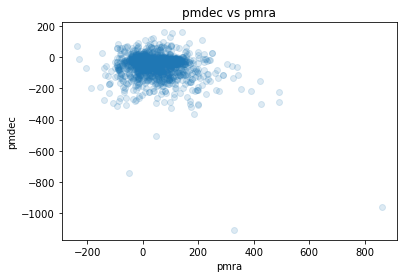

In [9]:
plot_axes(hyades_sample, "pmra", "pmdec")

Based on my cuts in parallax and position and my plot in proper motion space, I can see that most of the stars are grouped together and are not uniformly spread out. I will also try making a color-magnitude diagram with this data set and only use the parallaxes of the sourcese to convert from apparent magnitude to absolute magnitude. 

In [10]:
def make_HRD(tbl, cluster_name):
    """outputs and saves a plot of the color-magnitude (HRD), given a table
    of GAIA data and a string with the name of the cluster"""
    %matplotlib inline
    MG = tbl["phot_g_mean_mag"] + 5 + 5*np.log10(tbl['parallax']/1000)
    plt.figure(figsize=(8,7))
    
    plt.scatter(tbl["bp_rp"], MG, s=2, label="GAIA ERD3", color="black")
    
    plt.ylim(20,-5)
    plt.xlim(-1, 5)
    plt.xlabel(r"$G_{BP} - G_{RP}$", fontsize=20)
    plt.ylabel(r"$M_G$", fontsize=20)
    plt.title('Color-Absolute Magnitude Diagram for %s, n=%s'%(cluster_name, len(tbl)), fontsize=15)
    
    plt.legend()
    plt.tight_layout()
    plt.savefig("%s HRD.pdf"%cluster_name)
    plt.show()
    
def before_and_after(before_tbl, after_tbl, x_axis, y_axis):
    """this function is used to plot two tables that have columns with identical column names
    this will be used to show the difference in the data between the initial data grab
    and after it had been cleaned and reduced"""
    plt.figure()
    plt.scatter(before_tbl[x_axis], before_tbl[y_axis], alpha=0.15, label="before")
    plt.scatter(after_tbl[x_axis], after_tbl[y_axis], alpha=0.15, label="after")
    plt.xlabel(x_axis)
    plt.ylabel(y_axis)
    plt.title(y_axis+" vs "+ x_axis)
    plt.legend()
    plt.show()

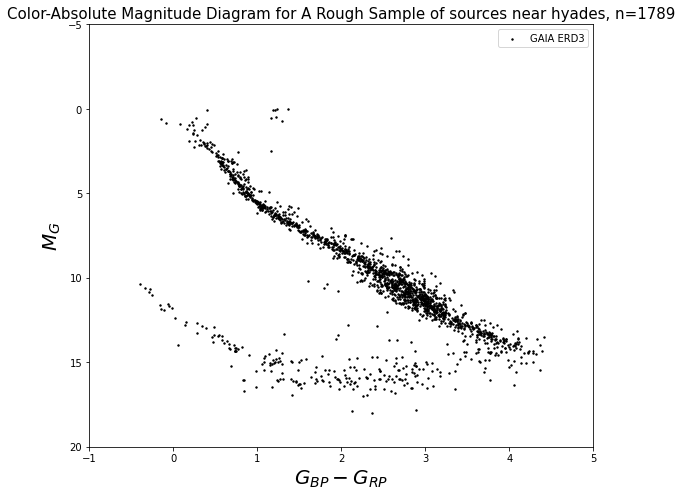

In [11]:
make_HRD(hyades_sample, "A Rough Sample of sources near hyades")

Now I will try making some cuts on the proper motion space and see how that changes the way the color-absolute magnitude diagram looks. Most of the points in the proper motion plot appear to be within a proper motion right ascension range of -100 mas/yr to 100 mas/yr and within a proper motion declination range of -150 mas/yr to 50 mas/yr. I will use these rough boundaries as cuts in proper motion and make a new color-absolute magnitude diagram to see how making cuts changes how it looks. 

In [12]:
hyades_initial_window = (hyades_parameters[0], hyades_parameters[1], 
                             hyades_parameters[4]*0.5, hyades_parameters[4]*1.5,
                             -100, 100, -150, 50)

hyades_initial_cuts = "SELECT * \
FROM gaiaedr3.gaia_source \
WHERE CONTAINS(POINT('ICRS',gaiaedr3.gaia_source.ra,gaiaedr3.gaia_source.dec),CIRCLE('ICRS',%s,%s,8))=1 \
AND parallax BETWEEN %s AND %s \
AND pmra BETWEEN %s AND %s \
AND pmdec BETWEEN %s and %s;"%hyades_initial_window

hyades_cuts = get_gaia_query(hyades_initial_cuts)
len(hyades_cuts)

1174

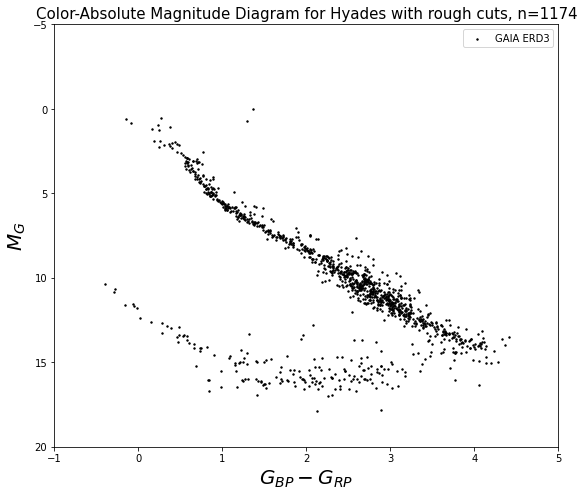

In [13]:
make_HRD(hyades_cuts, "Hyades with rough cuts")

These cuts in proper motion removed some sources, but there are still a large number of sources, as well as a "shadow" below what we expect to be the main sequence of the color-magnitude diagram. These cuts in proper motion were somewhat useful, but I suspect that much of the cleaning of this diagram will come from requiring a certain level of accuracy in the measurements.

In [14]:
hyades_initial_window = (hyades_parameters[0], hyades_parameters[1], 
                             hyades_parameters[4]*0.5, hyades_parameters[4]*1.5,
                             -100, 100, -150, 50)

hyades_astrometry_cuts = "SELECT * \
FROM gaiaedr3.gaia_source \
WHERE CONTAINS(POINT('ICRS',gaiaedr3.gaia_source.ra,gaiaedr3.gaia_source.dec),CIRCLE('ICRS',%s,%s,8))=1 \
AND abs(pmra_error/pmra)<0.10 \
AND abs(pmdec_error/pmdec)<0.10 \
AND pmra IS NOT NULL AND abs(pmra)>0 \
AND pmdec IS NOT NULL AND abs(pmdec)>0 \
AND parallax BETWEEN %s AND %s \
AND pmra BETWEEN %s AND %s \
AND pmdec BETWEEN %s and %s \
AND abs(parallax_error/parallax)<0.01;"%hyades_initial_window

hyades_cuts = get_gaia_query(hyades_astrometry_cuts)
len(hyades_cuts)

845

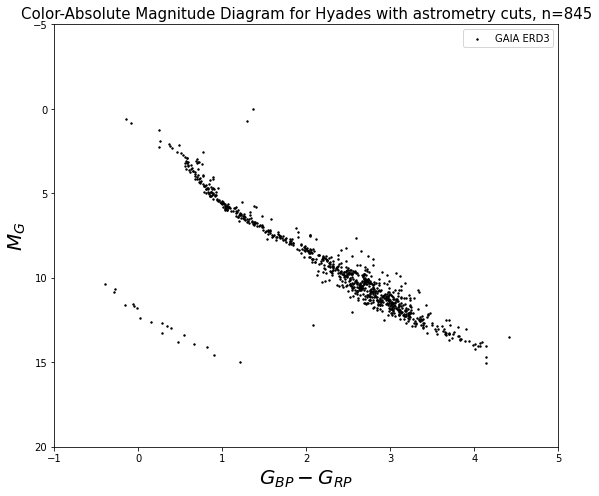

In [15]:
make_HRD(hyades_cuts, "Hyades with astrometry cuts")

Based on these cuts in astrometry, it is clear that the accuracy of the measuremets has a large impact on the appearance of the color-magnitude diagram. Inaccurately measured data, if not accounted for, can give us a completely different view of something we are studying. 

Now that I have done some exploration on the data, I will now take a more rigorous approach in trying to locate the cluster members. I queried the [SIMBAD Astronomical Database](http://simbad.u-strasbg.fr/simbad/) and pulled the values of the clusters' right ascension, declination, proper motion in the right ascension and declination, as well as the cluster's parallax. The parallax for NGC 6397 was not available on SIMBAD, which caused a `nan` to be stored in the parallax parameter, so I used the parallax determined by [Brown et al, 2018](https://arxiv.org/abs/1803.02927) as the nominal parallax ($\pi = 0.418 mas$). I then used these nominal values to set my window size for the queries to Gaia. I initially following the procedure outlined in [Babusiaux et al](https://arxiv.org/abs/1804.09378) to exclude any sources with unreliable astrometry and photometry. Using a `parallax_error/parallax < 0.01` proved to be too restrictive for the more distant M67 and NGC6397. For these, I used a `parallax_error/parallax` of 0.05 and 0.2, respectively.

In [16]:
#defined to be +- 100 for both the pmra, pmdec and +- 10 for the parallax; from the value on SIMBAD
#(pmra-100, pmra+100, pmdec-100, pmdec+100, parallax-10, parallax+10)

hyades_window = (hyades_parameters[0], hyades_parameters[1], 
                 hyades_parameters[2]-100, hyades_parameters[2]+100, 
                 hyades_parameters[3]-100, hyades_parameters[3]+100, 
                 hyades_parameters[4]-10, hyades_parameters[4]+10)

M67_window = (M67_parameters[0], M67_parameters[1], 
              M67_parameters[2]-100, M67_parameters[2]+100, 
              M67_parameters[3]-100, M67_parameters[3]+100, 
              M67_parameters[4]*(1-.5), M67_parameters[4]*(1+.5))

NGC6397_window = (NGC6397_parameters[0], NGC6397_parameters[1], 
                  NGC6397_parameters[2]-20, NGC6397_parameters[2]+20, 
                  NGC6397_parameters[3]-20, NGC6397_parameters[3]+20, 
                  NGC6397_parameters[4]*(1-0.75), NGC6397_parameters[4]*(1+0.75))

In [17]:
hyades_query = "SELECT * \
FROM gaiaedr3.gaia_source \
WHERE CONTAINS(POINT('ICRS',gaiaedr3.gaia_source.ra,gaiaedr3.gaia_source.dec),CIRCLE('ICRS',%s,%s,8))=1 \
AND abs(pmra_error/pmra)<0.10 \
AND abs(pmdec_error/pmdec)<0.10 \
AND pmra IS NOT NULL AND abs(pmra)>0 \
AND pmdec IS NOT NULL AND abs(pmdec)>0 \
AND pmra BETWEEN %s AND %s \
AND pmdec BETWEEN %s AND %s \
AND parallax BETWEEN %s AND %s \
AND visibility_periods_used>8 \
AND phot_g_mean_flux_over_error>50 \
AND phot_rp_mean_flux_over_error>20 \
AND phot_bp_mean_flux_over_error>20 \
AND phot_bp_rp_excess_factor < 1.3+0.06*power(phot_bp_mean_mag-phot_rp_mean_mag,2) \
AND phot_bp_rp_excess_factor > 1.0+0.015*power(phot_bp_mean_mag-phot_rp_mean_mag,2) \
AND astrometric_chi2_al/(astrometric_n_good_obs_al-5)<1.44*greatest(1,exp(-0.4*(phot_g_mean_mag-19.5))) \
AND abs(parallax_error/parallax)<0.01;"%hyades_window

M67_query = "SELECT * \
FROM gaiaedr3.gaia_source \
WHERE CONTAINS(POINT('ICRS',gaiaedr3.gaia_source.ra,gaiaedr3.gaia_source.dec),CIRCLE('ICRS',%s,%s,0.75))=1 \
AND abs(pmra_error/pmra)<0.10 \
AND abs(pmdec_error/pmdec)<0.10 \
AND pmra IS NOT NULL AND abs(pmra)>0 \
AND pmdec IS NOT NULL AND abs(pmdec)>0 \
AND pmra BETWEEN %s AND %s \
AND pmdec BETWEEN %s AND %s \
AND parallax BETWEEN %s AND %s \
AND visibility_periods_used>8 \
AND phot_g_mean_flux_over_error>20 \
AND phot_rp_mean_flux_over_error>15 \
AND phot_bp_mean_flux_over_error>15 \
AND phot_bp_rp_excess_factor < 1.3+0.06*power(phot_bp_mean_mag-phot_rp_mean_mag,2) \
AND phot_bp_rp_excess_factor > 1.0+0.015*power(phot_bp_mean_mag-phot_rp_mean_mag,2) \
AND astrometric_chi2_al/(astrometric_n_good_obs_al-5)<1.44*greatest(1,exp(-0.4*(phot_g_mean_mag-19.5))) \
AND abs(parallax_error/parallax)<0.05;"%M67_window

NGC6397_query = "SELECT * \
FROM gaiaedr3.gaia_source \
WHERE CONTAINS(POINT('ICRS',gaiaedr3.gaia_source.ra,gaiaedr3.gaia_source.dec),CIRCLE('ICRS',%s,%s,0.5))=1 \
AND abs(pmra_error/pmra)<0.10 \
AND abs(pmdec_error/pmdec)<0.10 \
AND pmra IS NOT NULL AND abs(pmra)>0 \
AND pmdec IS NOT NULL AND abs(pmdec)>0 \
AND pmra BETWEEN %s AND %s \
AND pmdec BETWEEN %s AND %s \
AND parallax BETWEEN %s AND %s \
AND visibility_periods_used>8 \
AND phot_g_mean_flux_over_error>15 \
AND phot_rp_mean_flux_over_error>10 \
AND phot_bp_mean_flux_over_error>10 \
AND phot_bp_rp_excess_factor < 1.3+0.06*power(phot_bp_mean_mag-phot_rp_mean_mag,2) \
AND phot_bp_rp_excess_factor > 1.0+0.015*power(phot_bp_mean_mag-phot_rp_mean_mag,2) \
AND astrometric_chi2_al/(astrometric_n_good_obs_al-5)<1.44*greatest(1,exp(-0.4*(phot_g_mean_mag-19.5))) \
AND abs(parallax_error/parallax)<0.2;"%NGC6397_window

In [18]:
hyades = get_gaia_query(hyades_query)
len(hyades)

712

In [19]:
M67 = get_gaia_query(M67_query)
len(M67)

1361

In [20]:
NGC6397 = get_gaia_query(NGC6397_query)
len(NGC6397)

8458

I then calculated the distance of each source from the center of its respective cluster and sorted the sources based on how close they were to the center. To determine which sources were cluster members, I calculated the standard deviation of the distances from the center and used it as a threshold. Sources with a distance higher than one standard deviation were not included in the cluster, and sources with distances less than or equal to one standard deviation were included in the cluster. 

In [21]:
def calc_distance(tbl, parameters):
    d_ra = parameters[0] - tbl["ra"]
    d_dec = parameters[1] - tbl["dec"]
    d_pmra = parameters[2] - tbl["pmra"]
    d_pmdec = parameters[3] - tbl["pmdec"]
    d_parallax = parameters[4] - tbl["parallax"]
    distance = np.sqrt(d_ra**2 + d_dec**2 + d_pmra**2 + d_pmdec**2 + d_parallax**2)
    return distance

In [22]:
hyades_dist = calc_distance(hyades, hyades_parameters)
M67_dist = calc_distance(M67, M67_parameters)
NGC6397_dist = calc_distance(NGC6397, NGC6397_parameters)

In [23]:
hyades.add_column(hyades_dist, name="distance")
M67.add_column(M67_dist, name="distance")
NGC6397.add_column(NGC6397_dist, name="distance")

In [24]:
hyades.sort("distance")
M67.sort("distance")
NGC6397.sort("distance")

In [25]:
hyades_SD = np.std(hyades["distance"])
M67_SD = np.std(M67["distance"])
NGC6397_SD = np.std(NGC6397["distance"])

hyades_candidates_indices = np.where(hyades["distance"] <= hyades_SD)
M67_candidates_indices = np.where(M67["distance"] <= M67_SD)
NGC6397_candidates_indices = np.where(NGC6397["distance"] <= NGC6397_SD)

hyades_candidates = hyades[hyades_candidates_indices]
M67_candidates = M67[M67_candidates_indices]
NGC6397_candidates = NGC6397[NGC6397_candidates_indices]

After making more accurate cuts in astrometry and photometry, along with finding the sources nearest to the center of the cluster in phase space, we are left with a greatly reduced data set. Comparing the first data set I took of the hyades at the beginning of the lab to what I have reduced it down to by now, we can see how effective cleaning the data was. The amount of sources was reduced from 1789 down to 332. 

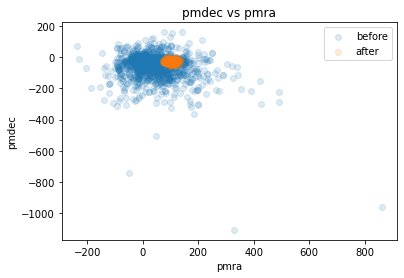

In [26]:
before_and_after(hyades_sample, hyades_candidates, "pmra", "pmdec")

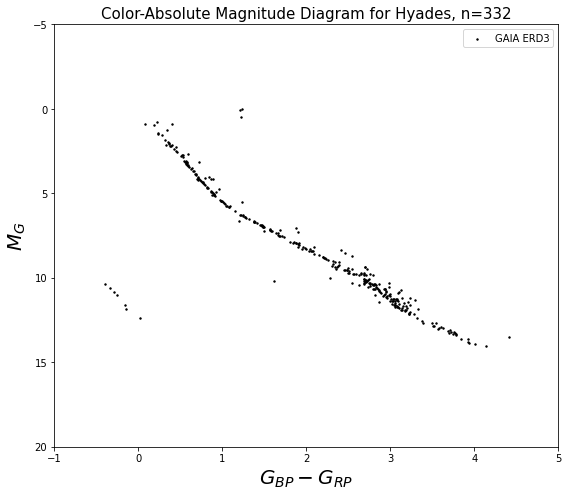

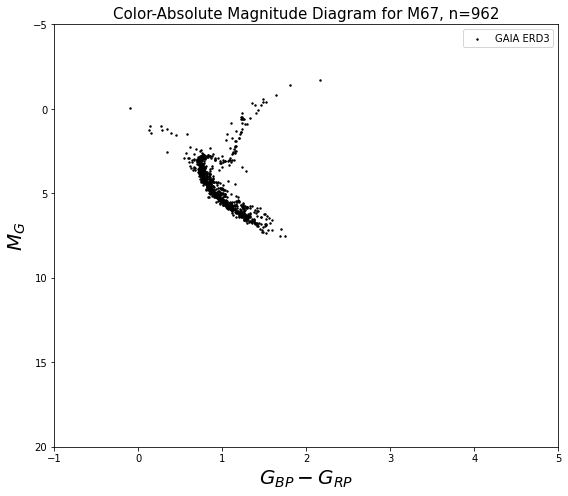

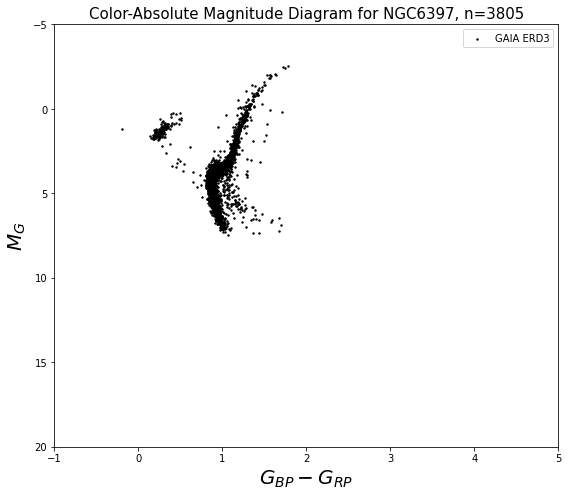

In [27]:
make_HRD(hyades_candidates, "Hyades")
make_HRD(M67_candidates, "M67")
make_HRD(NGC6397_candidates, "NGC6397")

Now that I have generated my color-magnitude diagrams, I will compare the empirical data with theoretical models from [MIST](http://waps.cfa.harvard.edu/MIST/) and [PARSEC](http://stev.oapd.inaf.it/cgi-bin/cmd_3.4)

This cell downloads and unzips the MIST isochrone files. Only need to run this cell if directory does not already contain the .cmd files

In [28]:
#MIST isochrone near hyades age, metallicity downloads
!wget http://waps.cfa.harvard.edu/MIST/tmp/MIST_iso_601d229810a41.iso.zip
!wget http://waps.cfa.harvard.edu/MIST/tmp/MIST_iso_601d245096a3e.iso.zip
!wget http://waps.cfa.harvard.edu/MIST/tmp/MIST_iso_601d24d9df3fa.iso.zip
!wget http://waps.cfa.harvard.edu/MIST/tmp/MIST_iso_601d2a52d103b.iso.zip
!wget http://waps.cfa.harvard.edu/MIST/tmp/MIST_iso_601d2ac4a93e5.iso.zip
!wget http://waps.cfa.harvard.edu/MIST/tmp/MIST_iso_601d2b98f0e36.iso.zip
!wget http://waps.cfa.harvard.edu/MIST/tmp/MIST_iso_601d2f86082da.iso.zip
!wget http://waps.cfa.harvard.edu/MIST/tmp/MIST_iso_601d2fe7049f2.iso.zip
!wget http://waps.cfa.harvard.edu/MIST/tmp/MIST_iso_601d3044a9d83.iso.zip
!wget http://waps.cfa.harvard.edu/MIST/tmp/MIST_iso_601d3094ba43d.iso.zip
!wget http://waps.cfa.harvard.edu/MIST/tmp/MIST_iso_601d30f159f3a.iso.zip
    
#MIST isochrone near M67 age, metallicity downloads
!wget http://waps.cfa.harvard.edu/MIST/tmp/MIST_iso_601d3f7e2b2fe.iso.zip
!wget http://waps.cfa.harvard.edu/MIST/tmp/MIST_iso_601d419614662.iso.zip
!wget http://waps.cfa.harvard.edu/MIST/tmp/MIST_iso_601d41a871dc6.iso.zip
!wget http://waps.cfa.harvard.edu/MIST/tmp/MIST_iso_601d42ba4108c.iso.zip
!wget http://waps.cfa.harvard.edu/MIST/tmp/MIST_iso_601d4220b4865.iso.zip
!wget http://waps.cfa.harvard.edu/MIST/tmp/MIST_iso_601d424e8850d.iso.zip
!wget http://waps.cfa.harvard.edu/MIST/tmp/MIST_iso_601d43002fc94.iso.zip
!wget http://waps.cfa.harvard.edu/MIST/tmp/MIST_iso_601d43445ac8c.iso.zip
!wget http://waps.cfa.harvard.edu/MIST/tmp/MIST_iso_601d4378c370e.iso.zip
    
#MIST isochrone near NGC6397 age, metallicity downloads
!wget http://waps.cfa.harvard.edu/MIST/tmp/MIST_iso_601ef66514b12.iso.zip
!wget http://waps.cfa.harvard.edu/MIST/tmp/MIST_iso_601f18678ff95.iso.zip
!wget http://waps.cfa.harvard.edu/MIST/tmp/MIST_iso_601ef73081511.iso.zip

#unzipping downloaded hyades MIST files
!unzip MIST_iso_601d229810a41.iso.zip
!unzip MIST_iso_601d245096a3e.iso.zip
!unzip MIST_iso_601d24d9df3fa.iso.zip
!unzip MIST_iso_601d2a52d103b.iso.zip
!unzip MIST_iso_601d2ac4a93e5.iso.zip
!unzip MIST_iso_601d2b98f0e36.iso.zip
!unzip MIST_iso_601d2f86082da.iso.zip
!unzip MIST_iso_601d2fe7049f2.iso.zip
!unzip MIST_iso_601d3044a9d83.iso.zip
!unzip MIST_iso_601d3094ba43d.iso.zip
!unzip MIST_iso_601d30f159f3a.iso.zip

#unzipping downloaded M67 MIST files
!unzip MIST_iso_601d3f7e2b2fe.iso.zip
!unzip MIST_iso_601d419614662.iso.zip
!unzip MIST_iso_601d41a871dc6.iso.zip
!unzip MIST_iso_601d42ba4108c.iso.zip
!unzip MIST_iso_601d4220b4865.iso.zip
!unzip MIST_iso_601d424e8850d.iso.zip
!unzip MIST_iso_601d43002fc94.iso.zip
!unzip MIST_iso_601d43445ac8c.iso.zip
!unzip MIST_iso_601d4378c370e.iso.zip

#unzipping downloaded NGC6397 MIST files
!unzip MIST_iso_601ef66514b12.iso.zip
!unzip MIST_iso_601f18678ff95.iso.zip
!unzip MIST_iso_601ef73081511.iso.zip

--2021-02-06 15:48:09--  http://waps.cfa.harvard.edu/MIST/tmp/MIST_iso_601d229810a41.iso.zip
Resolving waps.cfa.harvard.edu (waps.cfa.harvard.edu)... 108.59.80.241
Connecting to waps.cfa.harvard.edu (waps.cfa.harvard.edu)|108.59.80.241|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 254130 (248K) [application/zip]
Saving to: ‘MIST_iso_601d229810a41.iso.zip’

MIST_iso_601d229810 100%[===================>] 248.17K  1.04MB/s    in 0.2s    

2021-02-06 15:48:09 (1.04 MB/s) - ‘MIST_iso_601d229810a41.iso.zip’ saved [254130/254130]

--2021-02-06 15:48:09--  http://waps.cfa.harvard.edu/MIST/tmp/MIST_iso_601d245096a3e.iso.zip
Resolving waps.cfa.harvard.edu (waps.cfa.harvard.edu)... 108.59.80.241
Connecting to waps.cfa.harvard.edu (waps.cfa.harvard.edu)|108.59.80.241|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 253829 (248K) [application/zip]
Saving to: ‘MIST_iso_601d245096a3e.iso.zip’

MIST_iso_601d245096 100%[===================>] 247.88K   

MIST_iso_601d42ba41 100%[===================>] 236.45K  1.05MB/s    in 0.2s    

2021-02-06 15:48:16 (1.05 MB/s) - ‘MIST_iso_601d42ba4108c.iso.zip’ saved [242129/242129]

--2021-02-06 15:48:16--  http://waps.cfa.harvard.edu/MIST/tmp/MIST_iso_601d4220b4865.iso.zip
Resolving waps.cfa.harvard.edu (waps.cfa.harvard.edu)... 108.59.80.241
Connecting to waps.cfa.harvard.edu (waps.cfa.harvard.edu)|108.59.80.241|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 247469 (242K) [application/zip]
Saving to: ‘MIST_iso_601d4220b4865.iso.zip’

MIST_iso_601d4220b4 100%[===================>] 241.67K  1.12MB/s    in 0.2s    

2021-02-06 15:48:17 (1.12 MB/s) - ‘MIST_iso_601d4220b4865.iso.zip’ saved [247469/247469]

--2021-02-06 15:48:17--  http://waps.cfa.harvard.edu/MIST/tmp/MIST_iso_601d424e8850d.iso.zip
Resolving waps.cfa.harvard.edu (waps.cfa.harvard.edu)... 108.59.80.241
Connecting to waps.cfa.harvard.edu (waps.cfa.harvard.edu)|108.59.80.241|:80... connected.
HTTP request sent,

In [29]:
#reading in MIST isochrones corresponding to the Hyades to tables for use
hyades_age_890_z_013 = Table.read("MIST_iso_601d229810a41.iso.cmd", format='ascii', header_start=-1)
hyades_age_890_z_017 = Table.read("MIST_iso_601d245096a3e.iso.cmd", format='ascii', header_start=-1)
hyades_age_890_z_007 = Table.read("MIST_iso_601d24d9df3fa.iso.cmd", format='ascii', header_start=-1)
hyades_age_890_z_000 = Table.read("MIST_iso_601d2a52d103b.iso.cmd", format='ascii', header_start=-1)
hyades_age_890_z_025 = Table.read("MIST_iso_601d2ac4a93e5.iso.cmd", format='ascii', header_start=-1)
hyades_age_890_z_035 = Table.read("MIST_iso_601d2b98f0e36.iso.cmd", format='ascii', header_start=-1)
hyades_age_875_z_017 = Table.read("MIST_iso_601d2f86082da.iso.cmd", format='ascii', header_start=-1)
hyades_age_880_z_017 = Table.read("MIST_iso_601d2fe7049f2.iso.cmd", format='ascii', header_start=-1)
hyades_age_885_z_017 = Table.read("MIST_iso_601d3044a9d83.iso.cmd", format='ascii', header_start=-1)
hyades_age_895_z_017 = Table.read("MIST_iso_601d3094ba43d.iso.cmd", format='ascii', header_start=-1)
hyades_age_900_z_017 = Table.read("MIST_iso_601d30f159f3a.iso.cmd", format='ascii', header_start=-1)

#reading in MIST isochrones corresponding to the M67 to tables for use
M67_age_954_z_003 = Table.read("MIST_iso_601d3f7e2b2fe.iso.cmd", format='ascii', header_start=-1)
M67_age_800_z_003 = Table.read("MIST_iso_601d419614662.iso.cmd", format='ascii', header_start=-1)
M67_age_800_z_neg_005 = Table.read("MIST_iso_601d41a871dc6.iso.cmd", format='ascii', header_start=-1)
M67_age_1000_z_003 = Table.read("MIST_iso_601d42ba4108c.iso.cmd", format='ascii', header_start=-1)
M67_age_954_z_neg_005 = Table.read("MIST_iso_601d4220b4865.iso.cmd", format='ascii', header_start=-1)
M67_age_1000_z_neg_005 = Table.read("MIST_iso_601d424e8850d.iso.cmd", format='ascii', header_start=-1)
M67_age_800_z_005 = Table.read("MIST_iso_601d43002fc94.iso.cmd", format='ascii', header_start=-1)
M67_age_954_z_005 = Table.read("MIST_iso_601d43445ac8c.iso.cmd", format='ascii', header_start=-1)
M67_age_1000_z_005 = Table.read("MIST_iso_601d4378c370e.iso.cmd", format='ascii', header_start=-1)

#reading in MIST isochrones corresponding to the M67 to tables for use
NGC6397_z_minus_3 = Table.read("MIST_iso_601ef66514b12.iso.cmd", format='ascii', header_start=-1)
NGC6397_z_minus_2 = Table.read("MIST_iso_601f18678ff95.iso.cmd", format='ascii', header_start=-1)
NGC6397_z_minus_1  = Table.read("MIST_iso_601ef73081511.iso.cmd", format='ascii', header_start=-1)

#reading PARSEC grids corresponding to the clusters
hyades_PARSEC_isochrones = Table.read("output151919507029.dat", format="ascii")
M67_PARSEC_isochrones = Table.read("output846324854138.dat", format="ascii")
NGC6397_PARSEC_isochrones = Table.read("output935838925493.dat", format="ascii")

In [30]:
def PARSEC_indices(tbl, start_age, stop_age, step_age, start_z, stop_z, step_z):
    """returns a list containing the ranges of indices for each combination of age and metallicity for a 
    PARSEC table. These ranges will be used to select isochrones of interest for further plotting"""
    indices = []
    log_age = "col3"
    R_mag = "col31"
    B_mag = "col30"
    Mg = "col29"
    Fe_H = "col2"
    for age in np.arange(start_age, stop_age, step_age):
        for metallicity in np.arange(start_z, stop_z, step_z):
            index = np.where((tbl[log_age]==np.round(age, decimals=2)) & (tbl[Fe_H]==np.round(metallicity, decimals=3)))
            indices.append(index)
    return indices

def three_PARSEC_plots(PARSEC_tbl, GAIA, index_1, index_2, index_3, title):
    """takes in a table of PARSEC data and a table containing a selection of cluster members 
    as well as three sets of indices generated using the function above (PARSEC_indices) and 
    generates a nicely formatted plot displaying all three side by side"""
    tbl_1 = PARSEC_tbl[index_1]
    tbl_2 = PARSEC_tbl[index_2]
    tbl_3 = PARSEC_tbl[index_3]
    
    log_age = "col3"
    R_mag = "col31"
    B_mag = "col30"
    Mg = "col29"
    Fe_H = "col2"
    
    age_1 = tbl_1[log_age][0]
    m_1 = tbl_1[Fe_H][0]
    age_2 = tbl_2[log_age][0]
    m_2 = tbl_2[Fe_H][0]
    age_3 = tbl_3[log_age][0]
    m_3 = tbl_3[Fe_H][0]
    
    
    MG = GAIA["phot_g_mean_mag"] + 5 + 5*np.log10(GAIA['parallax']/1000)
    
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18,6), sharey=True)
    fig.suptitle(title)
    ax1.plot(tbl_1[B_mag] - tbl_1[R_mag], tbl_1[Mg], label=r"PARSEC: log(age) = %s, M/H = %s"%(age_1, m_1))
    ax1.set_ylabel(r"$M_G$")
    ax2.plot(tbl_2[B_mag] - tbl_2[R_mag], tbl_2[Mg], label=r"PARSEC: log(age) = %s, M/H = %s"%(age_2, m_2)) 
    ax3.plot(tbl_3[B_mag] - tbl_3[R_mag], tbl_3[Mg], label=r"PARSEC: log(age) = %s, M/H = %s"%(age_3, m_3))
    
    for ax in fig.get_axes():
        ax.label_outer()
        ax.set_ylim([20, -4])
        ax.set_xlim([-1,6])
        ax.set_xlabel(r"$G_{BP} - G_{RP}$")
        ax.scatter(GAIA["bp_rp"], MG, s=2, label="GAIA ERD3", color="black")
        ax.legend()
        
def three_MIST_plots(data, tbl_1, tbl_2, tbl_3, title):
    """over plots three CMD with GAIA data and mist isochrones"""
    age_1 = tbl_1["log10_isochrone_age_yr"][0]
    age_2 = tbl_2["log10_isochrone_age_yr"][0]
    age_3 = tbl_3["log10_isochrone_age_yr"][0]
    
    m_1 = tbl_1["[Fe/H]_init"][0]
    m_2 = tbl_2["[Fe/H]_init"][0]
    m_3 = tbl_3["[Fe/H]_init"][0]
    
    B_mag = "Gaia_BP_EDR3"
    R_mag = "Gaia_RP_EDR3"
    Mg = "Gaia_G_EDR3"
    
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18,6), sharey=True)
    fig.suptitle(title)
    
    MG = data["phot_g_mean_mag"] + 5 + 5*np.log10(data['parallax']/1000)
    
    ax1.plot(tbl_1[B_mag] - tbl_1[R_mag], tbl_1[Mg], label=r"MIST: log(age) = %s, Fe/H = %s"%(age_1, m_1))
    ax1.set_ylabel(r"$M_G$")
    ax2.plot(tbl_2[B_mag] - tbl_2[R_mag], tbl_2[Mg], label=r"MIST: log(age) = %s, Fe/H = %s"%(age_2, m_2)) 
    ax3.plot(tbl_3[B_mag] - tbl_3[R_mag], tbl_3[Mg], label=r"MIST: log(age) = %s, Fe/H = %s"%(age_3, m_3))
    
    
    for ax in fig.get_axes():
        ax.label_outer()
        ax.set_ylim([20, -4])
        ax.set_xlim([-1,6])
        ax.set_xlabel(r"$G_{BP} - G_{RP}$")
        ax.scatter(data["bp_rp"], MG, s=2, label="GAIA ERD3", color="black")
        ax.legend()
        
def MIST_isochrone(tbl, age):
    """takes in a table from MIST and returns only rows with the specified age"""
    wanted_rows = np.where(tbl["log10_isochrone_age_yr"]==age)
    return tbl[wanted_rows]

In [31]:
hyades_indices = PARSEC_indices(hyades_PARSEC_isochrones, 8.7, 9.06, 0.05, 0, 0.35, 0.06)
M67_indices = PARSEC_indices(M67_PARSEC_isochrones, 8.0, 10.1, 0.5, -0.5, 0.51, 0.5)
NGC6397_indices = PARSEC_indices(NGC6397_PARSEC_isochrones, 9, 10.1, 0.25, -2, -0.9, 0.25)

The PARSEC isochrone table for the Hyades was generated by querying log(age) beteen 8.7 and 9.5 in steps of 0.05, and $M/H$ between 0.0 and 0.25 in steps of 0.6. The extinction correction was calculated using $R(V) = A(V)/E(B-V)$ to calculate for $A(V)$, with $R(V) = 3.1$ and the values of $E(B-V)$ given in Table 2 of Babusiaux et al. In the case of the Hyades, the value was $E(B-V) = 0.01$, resulting in a value of $A(V)$ of 0.0031. The MIST isochrone tables were generated by requesting log(age) between 8.75 and 9.00 in steps of 0.05, and requesting $Fe/H$ values of 0.0, 0.13, 0.17, 0.25, and 0.35. And extinction correction factor of $A(V) = 0.01$ was used as well to generate the isochrones. 

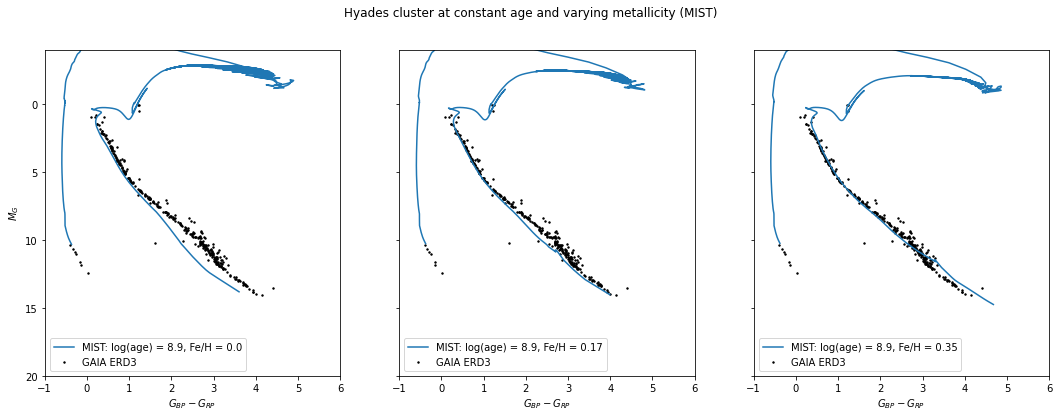

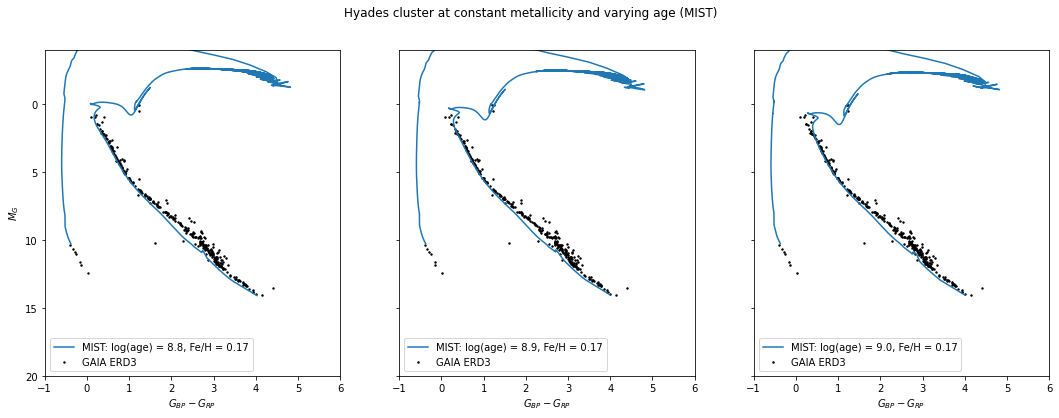

In [32]:
title = "Hyades cluster at constant age and varying metallicity (MIST)"
three_MIST_plots(hyades_candidates, hyades_age_890_z_000, hyades_age_890_z_017, hyades_age_890_z_035, title)

title = "Hyades cluster at constant metallicity and varying age (MIST)"
three_MIST_plots(hyades_candidates, hyades_age_880_z_017, hyades_age_890_z_017, hyades_age_900_z_017, title)

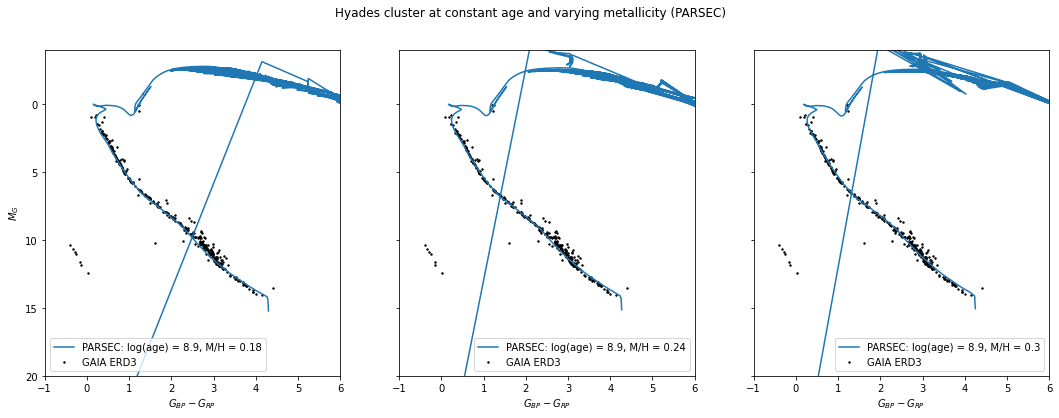

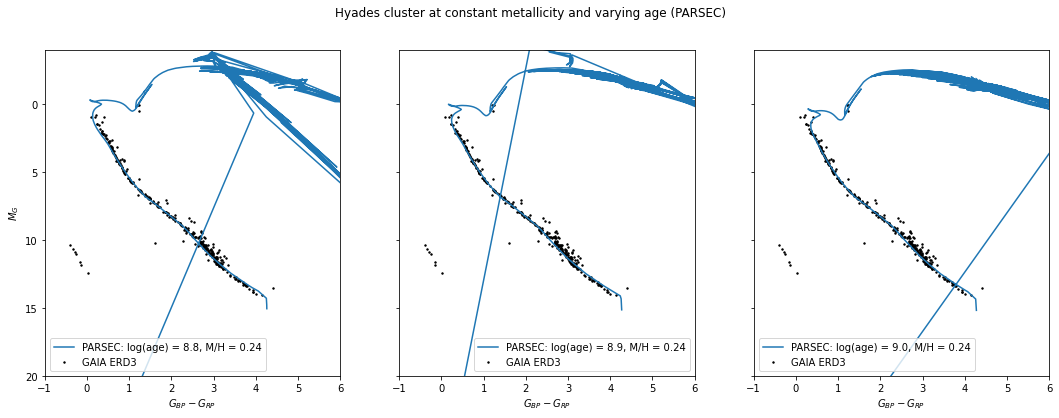

In [33]:
title = "Hyades cluster at constant age and varying metallicity (PARSEC)"
three_PARSEC_plots(hyades_PARSEC_isochrones, hyades_candidates, hyades_indices[27], 
                   hyades_indices[28], hyades_indices[29], title)

title = "Hyades cluster at constant metallicity and varying age (PARSEC)"
three_PARSEC_plots(hyades_PARSEC_isochrones, hyades_candidates, hyades_indices[16], 
                   hyades_indices[28], hyades_indices[40], title)

Due to the low amount of extinction because of the locality of the Hyades relative to Earth, there is a very small correction factor needed to adjust the theoretical isochrone to match the observed data ($A(V) = 0.0031$). Based on the MIST models, the Gaia data fits best with the isochrone with $log(age) = 8.90$ and $Z = 0.17$. The data fits most tightly near the brighter, bluer part of the HR diagram, while the less luminous, and redder part has some stars that lie above the theoretical prediction. This can be attributed to stars being in an unresolved binary system. This increase in brightness (decrease in magnitude) is due to Gaia detecting the flux from both stars, but due to the star's closeness to each other, they are unable to be resolved as two distinct sources. 

Due to the young age and small number of stars in the Hyades, there are very few stars that have left their main sequence. The stars that have left the main sequence can be seen in the giant branch (three stars above the main sequence) and in the white dwarf area, (ten stars below and to the right of the main sequence). 

When looking at the isochrones from PARSEC, we can see that the isochrone corresonding to log(age) = 8.90 have a main sequence that bisects the data, instead of falling underneath it. This is due to the fact that the isochrone was corrected for the unresolved binaries, that produces some sources that lie above where they would be if it were possible to resolve them as individual sources. 

Comparing the MIST and PARSEC models, we can see that both models provide good  fits for sources on the main sequence, and through some of the post main sequence evolution (up to around the asymptotoc giant branch), but beyond this, the PARSEC model appears to break down, instead of looping over the main sequence before ending with the white dwarfs and stellar remnants. The MIST model, however, fits the post asymptotic giant branch

The PARSEC isochrone table for M67 was generated by querying log(age) beteen 8 and 10 in steps of 0.5, and $M/H$ between -0.5 and 0.5 in steps of 0.5. The extinction correction was calculated using $R(V) = A(V)/E(B-V)$ to calculate for $A(V)$, with $R(V) = 3.1$ and the values of $E(B-V)$ given in Table 2 of Babusiaux et al. In the case of M67, the value was $E(B-V) = 0.037$, resulting in a value of $A(V)$ of 0.1147. The MIST isochrone tables were generated by requesting log(age) of 8.0, 9.54, and 10.0, and requesting $Fe/H$ values of -0.5, 0.03, and 0.5. And extinction correction factor of $A(V) = 0.1147$ was used as well to generate the isochrones.

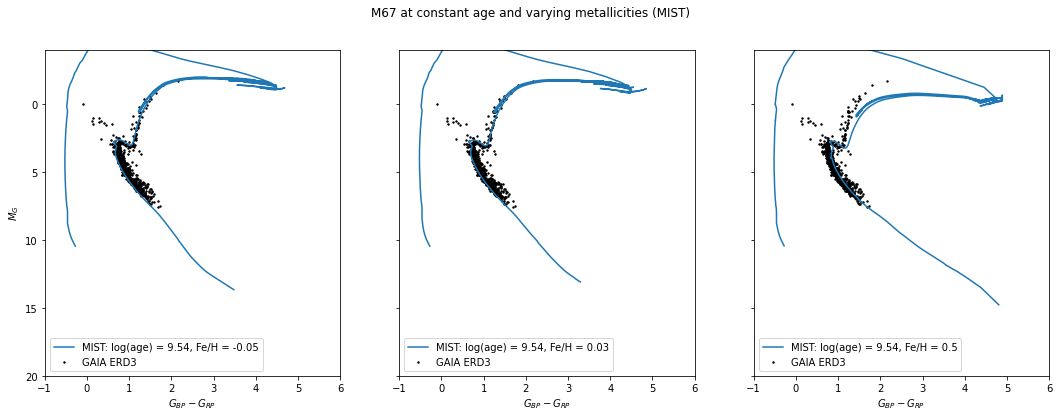

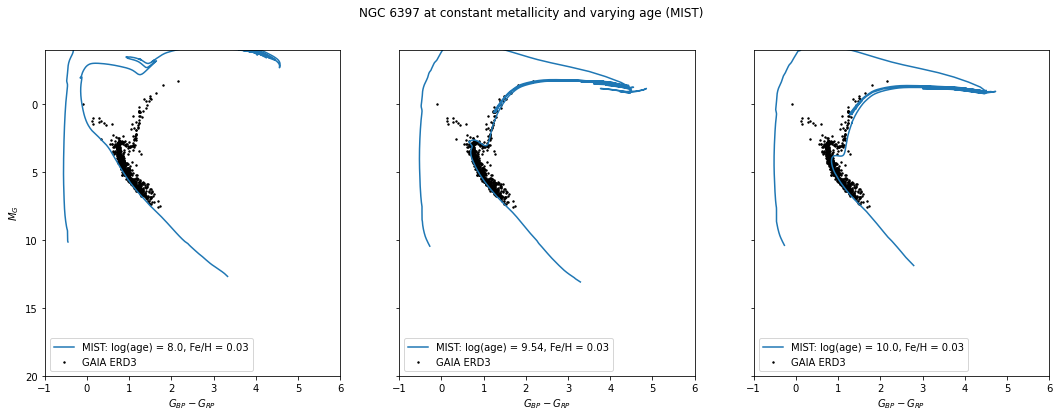

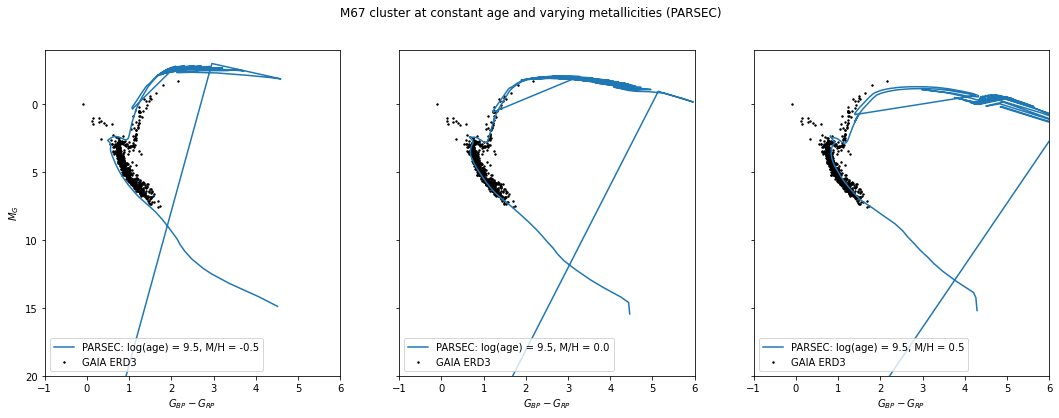

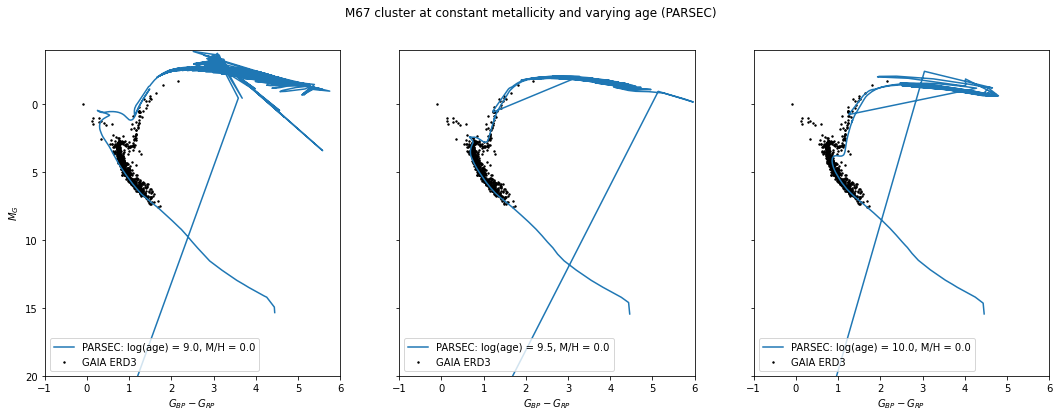

In [34]:
#MIST isochrones
title = "M67 at constant age and varying metallicities (MIST)"
three_MIST_plots(M67_candidates, M67_age_954_z_neg_005, M67_age_954_z_003, M67_age_954_z_005, title)

title = "NGC 6397 at constant metallicity and varying age (MIST)"
three_MIST_plots(M67_candidates, M67_age_800_z_003, M67_age_954_z_003, M67_age_1000_z_003, title)

#parsec
title = "M67 cluster at constant age and varying metallicities (PARSEC)"
three_PARSEC_plots(M67_PARSEC_isochrones, M67_candidates, M67_indices[9], 
                   M67_indices[10], M67_indices[11], title)

title = "M67 cluster at constant metallicity and varying age (PARSEC)"
three_PARSEC_plots(M67_PARSEC_isochrones, M67_candidates, M67_indices[7], 
                   M67_indices[10], M67_indices[13], title)

Comparing the fits of the MIST isochrones to the Gaia data for M67, I found that the best combination of age and metallicity was a log(age) of 9.54 and Fe/H of 0.03. For MIST isochrones with a lower age, I observed a main sequence turn off that was much higher on the main sequence, and for isochrones with a higer age, a main sqeuence turn off that appeared much lower on the main sequence. Changing the metallicity for a constant age showed varied the color of the cluster members. A lower metallicity prdicted that the whole cluster would appear more blue, while a higher metallicity would appear more red. Looking at the predictions from the PARSEC models, I saw similar changes in the model predictions.

Based on the higher number and older age, when compared to the Hyades, we can see that there are more stars in their post main sequece stages of evolution. M67 has a far higher number of stars on the red giant branch and asymptotic giant branch. However, no white dwarfs appear on the color-magnitude diagram. I do not believe that this inducates that there is a lack of white dwarfs in the cluster, but rather it is a result of the collection of the data. White  dwarfs are very dim, and M67 is likeley too far away for Gaia to detect high enough resolution data on the white dwarfs present. 

Looking at the main sequence of the cluster can reveal some discrepancies in the models used by MIST and PARSEC. The MIST models have a higher number of sources that are higher on the diagram (magnitude closer to zero) than the PARSEC model, which does a better job of accounting for the increased brightness due to unresolved binaries. When looking at the post asymptotic branch behavior of the models, we can see that the MIST model accurately predicts where the white dwarfs would appear, while the PARSEC model breaks down. 

The PARSEC isochrone table for NGC6307 was generated by querying log(age) beteen 9 and 10 in steps of 0.25, and $M/H$ between -2 and -1 in steps of 0.25. The extinction correction was calculated using $R(V) = A(V)/E(B-V)$ to calculate for $A(V)$, with $R(V) = 3.1$ and the values of $E(B-V)$ given in Table 2 of Babusiaux et al. In the case of M67, the value was $E(B-V) = 0.037$, resulting in a value of $A(V)$ of 0.558.The MIST isochrone tables were generated by requesting log(age) range between 9.5 and 10.3 in steps of 0.1, and requesting $Fe/H$ values of -3.0, -2.0, and -1.0. And extinction correction factor of $A(V) = 0.558$ was used as well to generate the isochrones. 

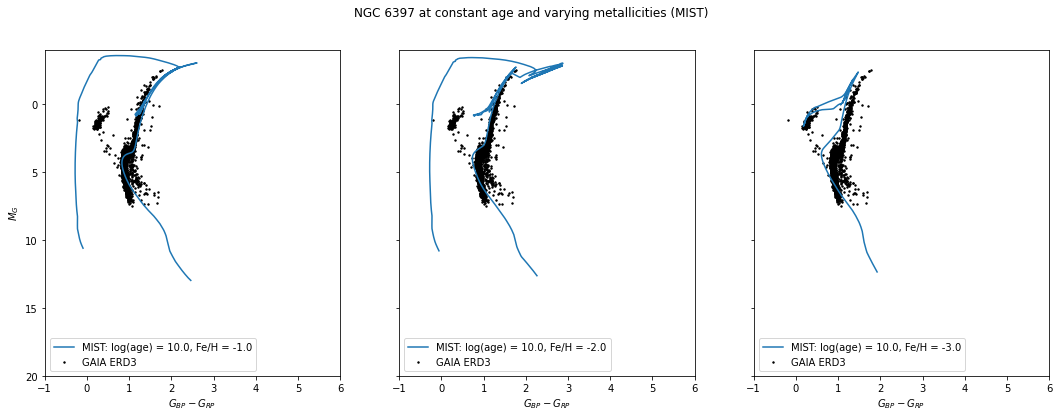

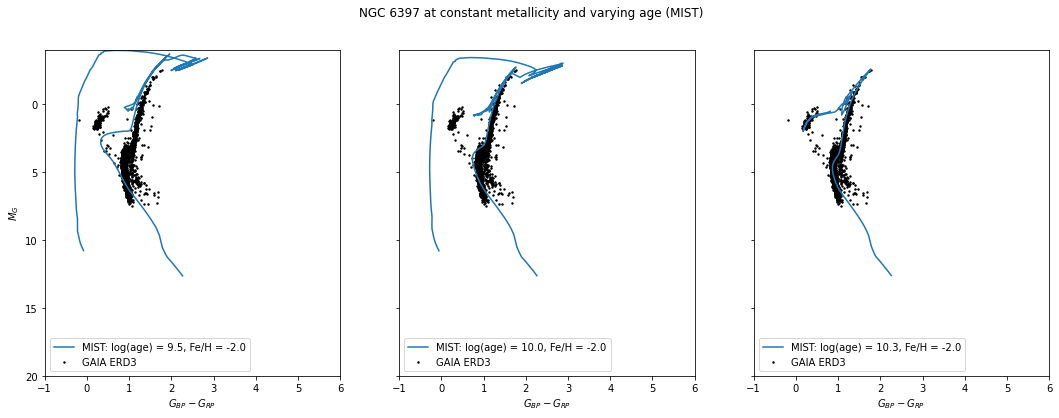

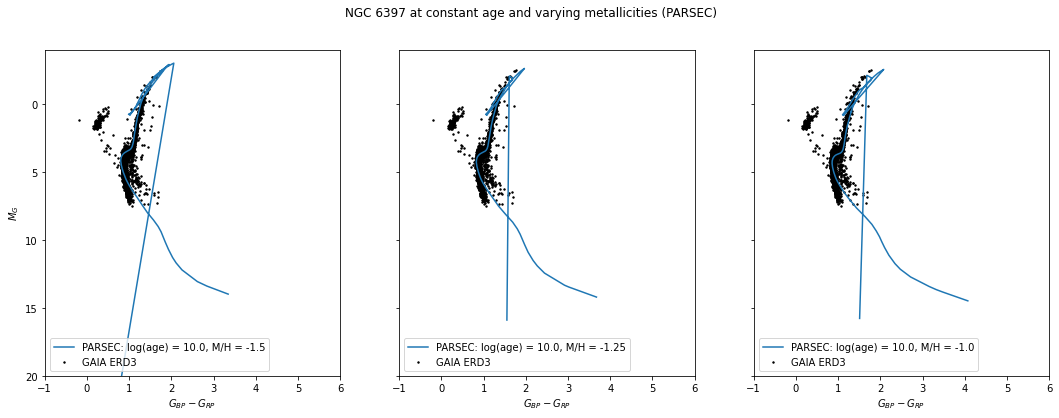

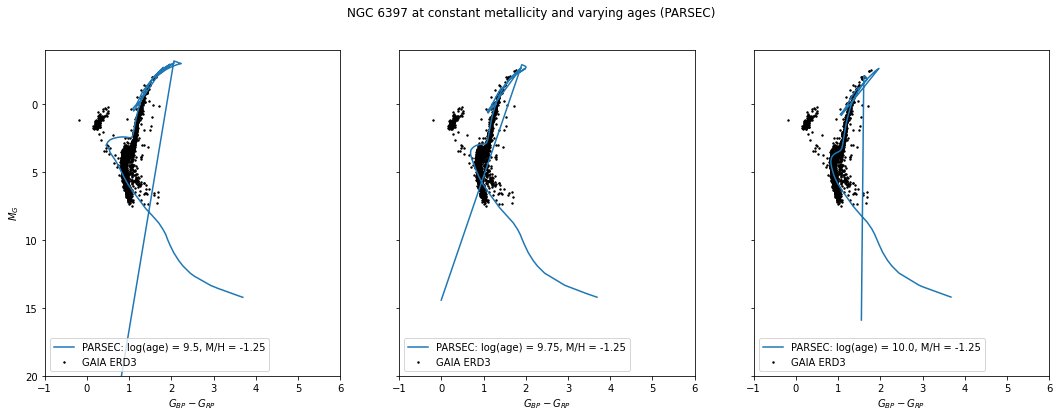

In [35]:
NGC6397_3_10 = MIST_isochrone(NGC6397_z_minus_3, 10)
NGC6397_2_10 = MIST_isochrone(NGC6397_z_minus_2, 10)
NGC6397_1_10 = MIST_isochrone(NGC6397_z_minus_1, 10)

NGC6397_2_95 = MIST_isochrone(NGC6397_z_minus_2, 9.5)
NGC6397_2_10 = MIST_isochrone(NGC6397_z_minus_2, 10)
NGC6397_2_103 = MIST_isochrone(NGC6397_z_minus_2, 10.3)

title = "NGC 6397 at constant age and varying metallicities (MIST)"
three_MIST_plots(NGC6397_candidates, NGC6397_1_10, NGC6397_2_10, NGC6397_3_10, title)

title = "NGC 6397 at constant metallicity and varying age (MIST)"
three_MIST_plots(NGC6397_candidates, NGC6397_2_95, NGC6397_2_10, NGC6397_2_103, title)

#PARSEC
title = "NGC 6397 at constant age and varying metallicities (PARSEC)"
three_PARSEC_plots(NGC6397_PARSEC_isochrones, NGC6397_candidates, NGC6397_indices[22],
                   NGC6397_indices[23], NGC6397_indices[24],title)

title = "NGC 6397 at constant metallicity and varying ages (PARSEC)"
three_PARSEC_plots(NGC6397_PARSEC_isochrones, NGC6397_candidates, NGC6397_indices[13], 
                   NGC6397_indices[18], NGC6397_indices[23],title)

Comparing the MIST isochrones to the Gaia data for NGC6397, I found that the best combination of age and metallicity was log(age) = 10 and Fe/H = -2. A new feature of the globular cluster was the high number of stars that appear after a gap in the main sequence. One possible reason for these stars is that they could be younger stars that have formed after the initial formation of the cluster and that is why they are still on the main sequence despite their high luminosity and age. This is unlikeley, due to the low formation rate of such high mass stars, as well as the low likelihood for stars to form later in a cluster's lifetime. This is most likely not what caused these blue stragglers to appear. 

Looking at the predictions of MIST and PARSEC models when compared to the Gaia data, I can see that MIST does have a part of the isochrone that predicts the blue stragglers for a higer age or metallicity, but due to this cluter's main sequence turn off, they were not good fits. There are also a high number of stars that lie above the main sequence in the MIST model, while the PARSEC model does a slightly better job of fitting them. These are stars in a binary system, and it makes sense that NGC6397, which was the furthest cluster has the highest number of them, as the binary stars are too close to each other to be independently resolved at such a distance. 